In [87]:
import matplotlib.pyplot as plot
import warnings
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, date
plt.rcParams.update({'font.size': 16})
from statsmodels.tsa.stattools import adfuller
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, Markdown, Latex
from sklearn.metrics import mean_absolute_error
import itertools
import pyodbc
pd.set_option("max_rows", None)

In [2]:
# connect to SQL (1st step)

# establish an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
'Server=DESKTOP-1VJ4H95;'
'Database=AdventureWorks2012;'
'Trusted_Connection=yes;')


In [3]:
# now that the database is connected to python pull the data needed (2nd step)

# pull orderdate Region and revenue  from SQL (AdventureWorks Database)
# plug your SQL query inside the """ """
pythonSQLobject=pd.read_sql_query("""
 SELECT
	
	(SSOH.OrderDate ) AS OrderDate
	,sum((SSOD.UnitPrice-SSOD.UnitPriceDiscount)*(SSOD.OrderQty))AS Revenue
	
	,SST.Name AS Region
    from [Sales].[SalesOrderDetail] AS SSOD
	LEFT JOIN [Sales].[SalesOrderHeader] AS SSOH 
	ON SSOH.SalesOrderID = SSOD.SalesOrderID
	LEFT JOIN [Sales].[SalesTerritory] AS SST
	ON SSOH.TerritoryID = SST.TerritoryID 
	GROUP BY (SSOH.OrderDate),SST.Name 
	
	
	  
""", conn)

conn.close() # please close it after 


In [4]:
pythonSQLobject.head() # have a look at the data

,OrderDate,Revenue,Region
0,2011-07-14,7156.54,Germany
1,2012-02-01,3578.27,France
2,2013-09-20,427.69,Canada
3,2014-05-30,6832.69,Southwest
4,2014-06-14,304.34,Australia


In [5]:
pythonSQLobject.shape # dimensions

(5831, 3)

In [6]:
pythonSQLobject['OrderDate'].min(), pythonSQLobject['OrderDate'].max()

(Timestamp('2011-05-31 00:00:00'), Timestamp('2014-06-30 00:00:00'))

In [7]:
# now let us extract the order date and revenue
df_New=pythonSQLobject[["OrderDate","Revenue"]].reset_index()

In [8]:
df_New.head(2)

,index,OrderDate,Revenue
0,0,2011-07-14,7156.54
1,1,2012-02-01,3578.27


In [9]:
#set index to start fro Orderdate and have a look at it
df_New = df_New.set_index('OrderDate')
df_New.head(2)

,index,Revenue
OrderDate,,
2011-07-14,0,7156.54
2012-02-01,1,3578.27


In [10]:
df_New.shape

(5831, 2)

In [11]:
df_New.isnull().sum()

index      0
Revenue    0
dtype: int64

In [12]:
#df_New=df_summary[["OrderDate","Revenue"]]

In [13]:
#df_New=df_New.set_index("OrderDate")
df_New = df_New['Revenue'].resample('MS').mean()


In [14]:
df_New

OrderDate
2011-05-01    62975.739612
2011-06-01     4780.321092
2011-07-01    21539.578063
2011-08-01    23114.450948
2011-09-01     5398.643503
2011-10-01    40989.902667
2011-11-01     6148.665178
2011-12-01    12129.412081
2012-01-01    31765.077610
2012-02-01    12943.306657
2012-03-01    24802.911726
2012-04-01    14999.017607
2012-05-01    24738.672333
2012-06-01    28569.403155
2012-07-01    22547.291060
2012-08-01    17282.918917
2012-09-01    29036.359618
2012-10-01    19898.933805
2012-11-01    11784.591301
2012-12-01    20364.245784
2013-01-01    14205.535613
2013-02-01    17185.621693
2013-03-01    22759.544498
2013-04-01    15743.037989
2013-05-01    22207.080728
2013-06-01    29234.002626
2013-07-01    22633.134519
2013-08-01    15204.541303
2013-09-01    21117.000821
2013-10-01    21532.757215
2013-11-01    15341.530965
2013-12-01    18537.036428
2014-01-01    19162.274063
2014-02-01     6860.128388
2014-03-01    32029.888151
2014-04-01     8320.249644
2014-05-01    2423

In [15]:
df_New.shape

(38,)

In [16]:
df_New.tail()

OrderDate
2014-02-01     6860.128388
2014-03-01    32029.888151
2014-04-01     8320.249644
2014-05-01    24231.952219
2014-06-01      239.052878
Freq: MS, Name: Revenue, dtype: float64

In [17]:
#  2014 Revenue data.

df_New['2014':]

OrderDate
2014-01-01    19162.274063
2014-02-01     6860.128388
2014-03-01    32029.888151
2014-04-01     8320.249644
2014-05-01    24231.952219
2014-06-01      239.052878
Freq: MS, Name: Revenue, dtype: float64

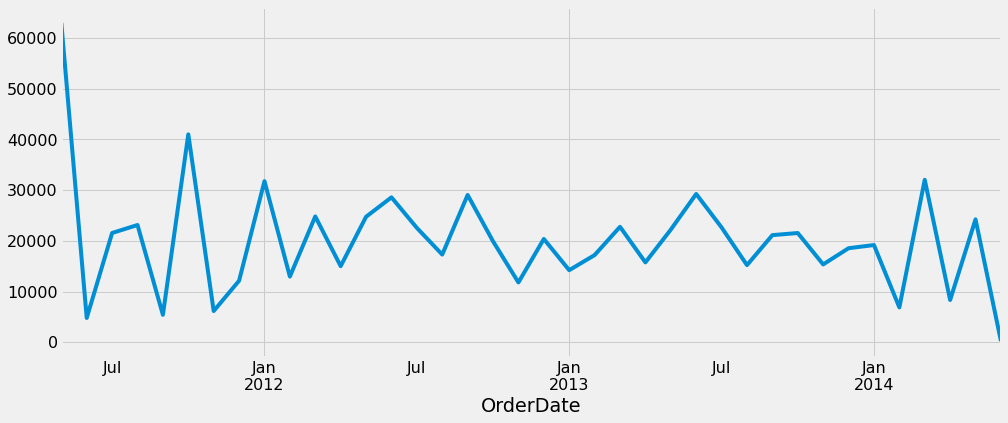

In [18]:
df_New.plot(figsize=(15, 6))
plt.show()

Text(0.5, 1.0, 'Revenue for the whole Region')

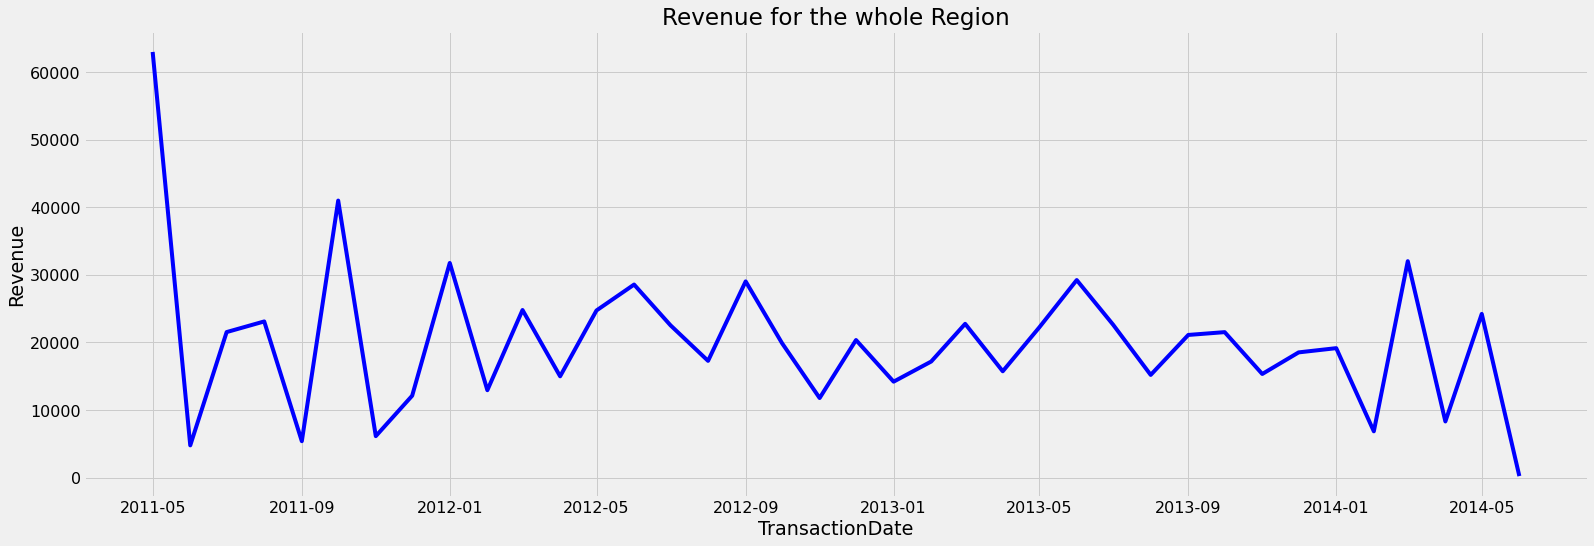

In [19]:


plt.figure(figsize=(24,8))
#tick_locations=[value for value in np.arange(40)]
#plt.xticks(tick_locations, rotation=45)
#plt.figure(figsize=(24, 8))
plt.plot(df_New,'b-')

plt.xlabel('TransactionDate'); plt.ylabel('Revenue'); plt.title('Revenue for the whole Region')
#plt.show();

### STATIONARIZE TIME SERIES


#### HERE WE ARE GOING TO USE TWO METHOD TO TEST FOR STATIONARITY OF OUR TIME SERIES DATA
#### OUR DATA MUST HAVE CONSTANT MEAN AND STANDARD DEVIATION IRESPECTIVE OF THE TIME OR SEASON IN ORDER TO  HAVE AN ACCURATE PREDICTION

### Dicker Fuller Test
##### It is clearly evident that there is an overall ZIG SAG trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the Dicker Fuller Test.

###### This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the df_summary is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis  then accept alternate hypothesis and then say that the series is stationary

In [20]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     ts_log.rolling(12).mean()
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(24,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #tick_locations=[value for value in np.arange(33)]
    #plt.xticks(tick_locations, rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print()
    if dfoutput[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and it is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")    
    

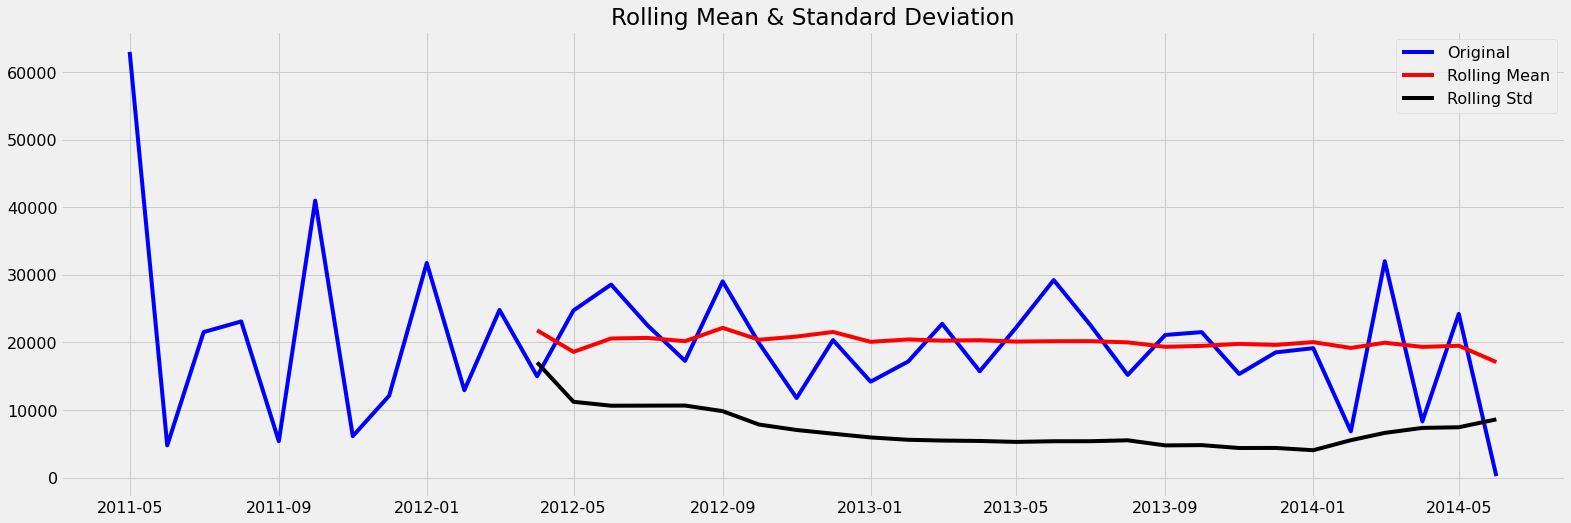

Results of Dickey-Fuller Test:
Test Statistic                -1.262596e+01
p-value                        1.541475e-23
#Lags Used                     0.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and it is stationary


In [21]:
plt.rcParams.update({'font.size': 16})
test_stationarity(df_New)



#### from the rolling mean we can see that the standard deviation and the mean value acrross different dates are constant but this is not enough we need to test for stationary using  augumented dick fuller test
#### Since p <0.05 and test statistic < critical values, we reject Null hypothesis which states that it is non stationary and accept the alternate hypothesis 

### The ARIMA Time Series Model

#### We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, 

#### we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 

#### Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:



#### We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

#### ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_New,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:843.1773535322247
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1068.053826800295
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:540.010259798033
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:280.3750461443379
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:563.095795787673
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:540.5086340927755
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:299.3273654940078
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:282.2855702153776
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:810.3566824364242
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:7186.141300229003
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:510.56999264191114
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:258.27816655997225
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:576.5325576537466
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:533.8971112769558
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:300.4043450103433
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:260.27728263329993
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:792.711317219851
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0,

### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 238.71 Therefore we should consider this to be optimal option.

## Fitting the ARIMA model

In [24]:
mod = sm.tsa.statespace.SARIMAX(df_New,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])








                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4675      0.627     -2.341      0.019      -2.696      -0.239
ma.L1         -0.8966      0.530     -1.691      0.091      -1.936       0.143
ar.S.L12      -0.8813      0.213     -4.145      0.000      -1.298      -0.465
ma.S.L12       0.7458      0.314      2.375      0.018       0.130       1.361
sigma2      9.176e+07   1.49e-09   6.18e+16      0.000    9.18e+07    9.18e+07


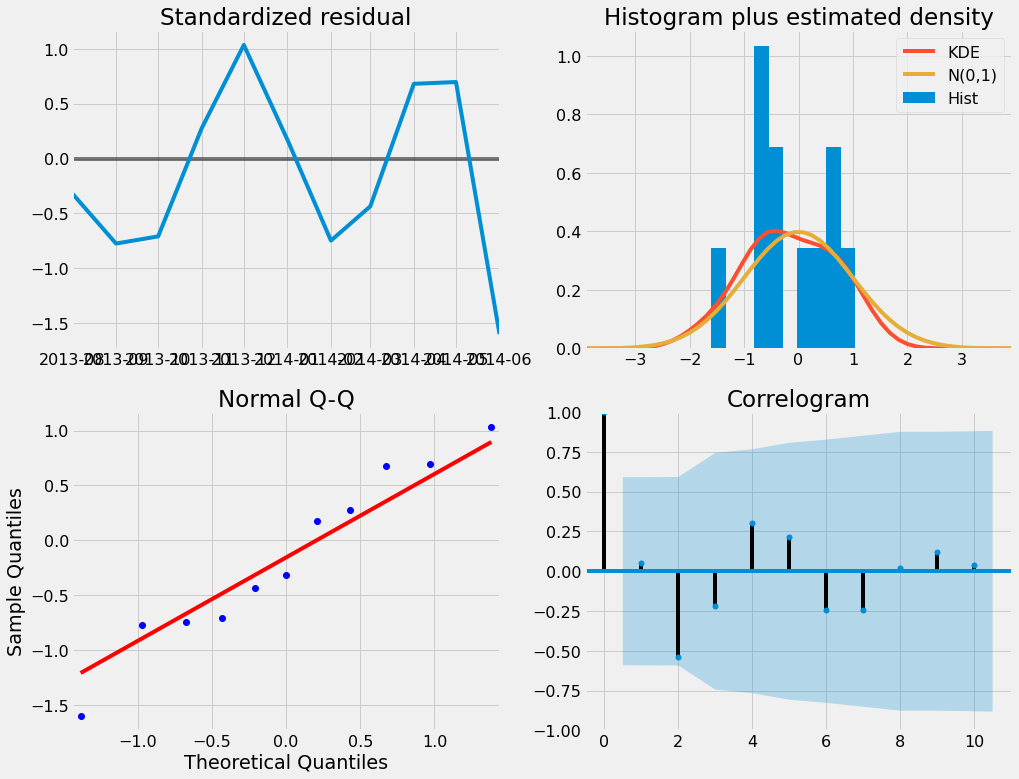

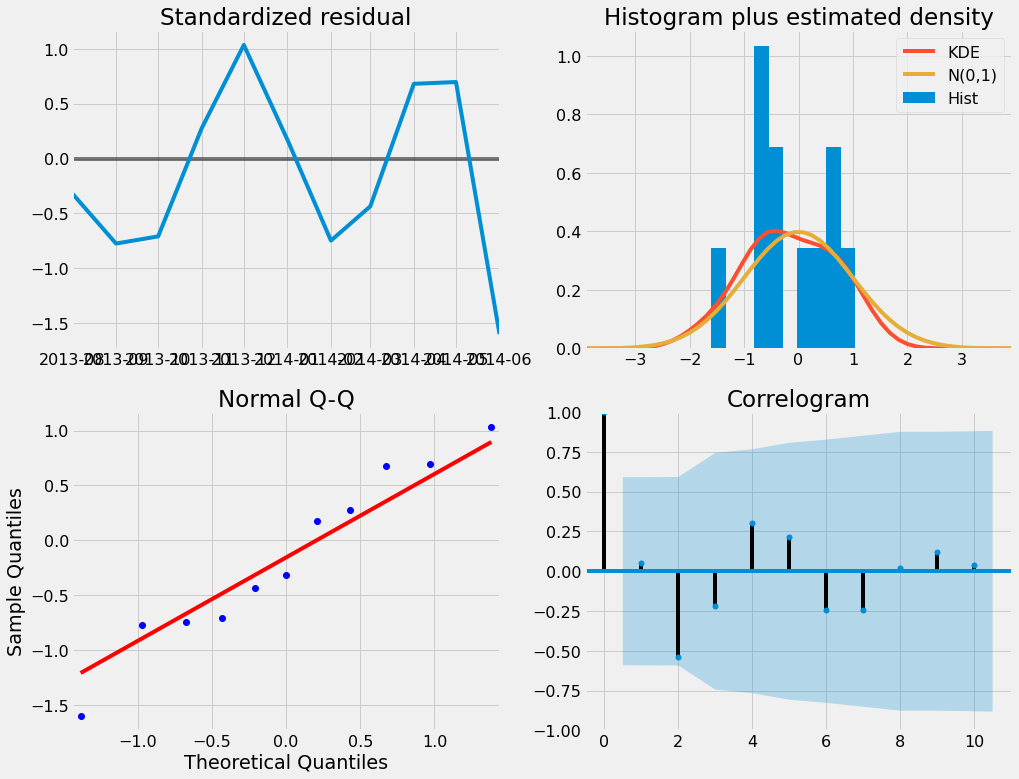

In [25]:
# The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(15, 12))


## Validating Forecasts

#### The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

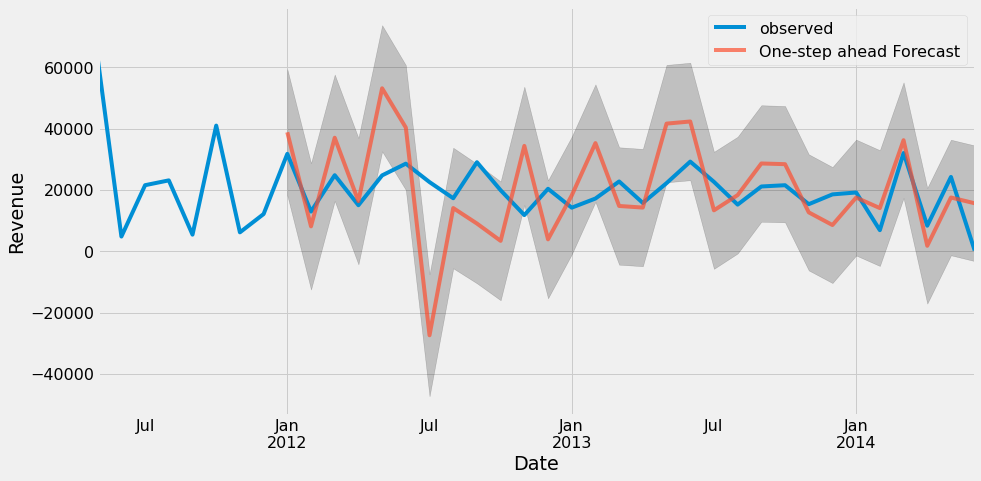

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01 '), dynamic=False)
pred_ci = pred.conf_int()

ax = df_New['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()

#plt.show()

#### it is always better to quantify the accuracy of our forecasts. We will use mean of residuals and the MSE (Mean Squared Error), which summarizes the average error

In [27]:
y_forecasted = pred.predicted_mean
y_truth = df_New['2011-05-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
residual_mean=np.mean(y_forecasted - y_truth)

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The mean of residuals is {}'.format(round(residual_mean, 2)))

The Root Mean Squared Error of our forecasts is 15050.14
The mean of residuals is 826.09


In [28]:
# print(y_forecasted)

#### Clearly with such statistical measures, we cannot accept that

In [29]:
#df_New_prophet = df_New.rename(column={'OrderDate': 'ds', 'Revenue': 'y'})
#df_New_prophet.head(2)

df_New_prophet=df_New.reset_index(level="OrderDate")
# ts_df_prophet
df_New_prophet.columns=['ds','y']
df_New_prophet.head(2)

,ds,y
0,2011-05-01,62975.739612
1,2011-06-01,4780.321092


In [30]:
from fbprophet import Prophet
#prophet reqiures a pandas df

model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(df_New_prophet) 

# predict for 60 which represnt five years months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 60, freq = 'MS') 

# now lets make the forecasts
forecast_prophet = model.predict(future)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
forecast_prophet.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
93,2019-02-01,259.055000,-10060.784361,1209.705523,258.428210,259.730946,-4669.830308,-4669.830308,-4669.830308,-4669.830308,-4669.830308,-4669.830308,0.0,0.0,0.0,-4410.775308
94,2019-03-01,74.667175,10100.404376,21441.553655,74.024890,75.365311,15585.663232,15585.663232,15585.663232,15585.663232,15585.663232,15585.663232,0.0,0.0,0.0,15660.330407
95,2019-04-01,-129.476489,-14131.817035,-2484.689122,-130.134266,-128.762802,-8533.316587,-8533.316587,-8533.316587,-8533.316587,-8533.316587,-8533.316587,0.0,0.0,0.0,-8662.793076
96,2019-05-01,-327.034874,28951.169253,40219.130290,-327.709530,-326.306670,34669.616808,34669.616808,34669.616808,34669.616808,34669.616808,34669.616808,0.0,0.0,0.0,34342.581934
97,2019-06-01,-531.178538,-20121.134536,-8720.465328,-531.859653,-530.424768,-13870.318960,-13870.318960,-13870.318960,-13870.318960,-13870.318960,-13870.318960,0.0,0.0,0.0,-14401.497497


In [32]:
forecast_prophet=forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# model.plot(forecast)
forecast_prophet.head(2)

,ds,yhat,yhat_lower,yhat_upper
0,2011-05-01,53583.449982,47989.857567,59433.300290
1,2011-06-01,4839.417420,-718.345958,10065.667763


In [33]:
pred_prophet = np.asarray(forecast_prophet['yhat'])
y_truth = df_New['2011':]

In [34]:
forecast_prophet2=forecast_prophet.groupby(['ds']).sum()['yhat']

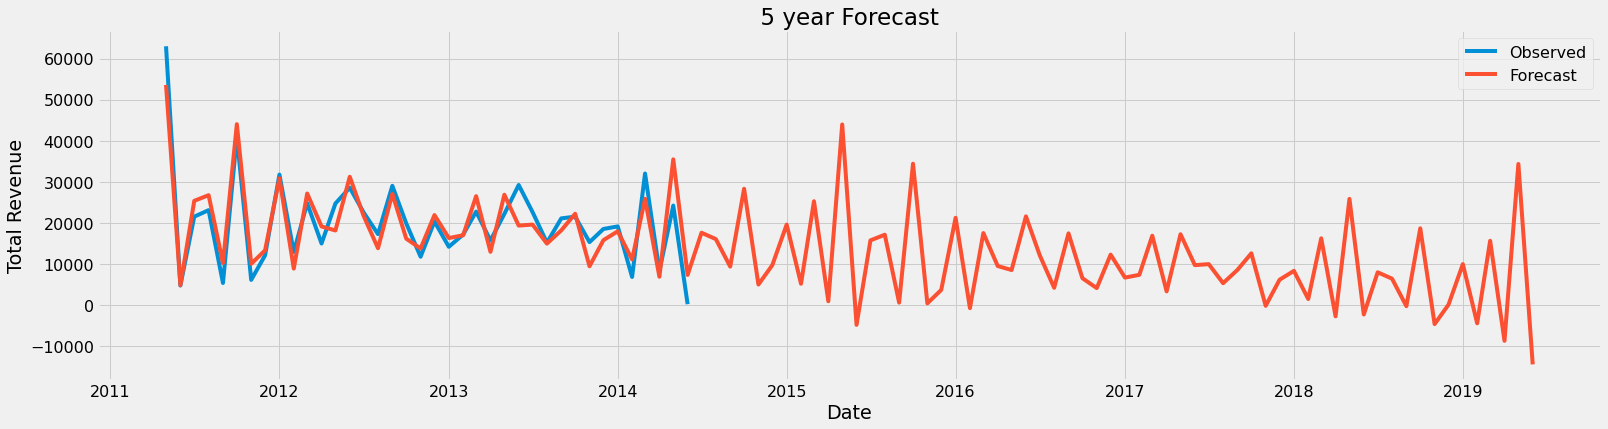

In [100]:
fig, ax = plt.subplots(figsize=(24, 6));
plt.plot(y_truth,label='Observed',alpha=2)
plt.plot(forecast_prophet2,label='Forecast',alpha=2)




ax.set_xlabel('Date')
ax.set_ylabel('Total Revenue')
plt.legend()
plt.title(" 5 year Forecast ")
plt.show()


In [43]:
y=pd.DataFrame({"OrderDate":forecast_prophet['ds'],"Observed_Sales":pd.Series(y_truth.values).round(1),
              "Predicted_Sales":(forecast_prophet['yhat']).round(1)
             })
y.head()

,OrderDate,Observed_Sales,Predicted_Sales
0,2011-05-01,62975.7,53583.4
1,2011-06-01,4780.3,4839.4
2,2011-07-01,21539.6,25380.7
3,2011-08-01,23114.5,26761.0
4,2011-09-01,5398.6,10249.7


In [37]:
# now let me convert the order date to quarter as requested.
import datetime as dt

In [89]:
y=pd.DataFrame({"Date":forecast_prophet['ds'].dt.year,"Date_In_Quarter":forecast_prophet['ds'].dt.quarter,"Observed":pd.Series(y_truth.values).round(1),
              "Predicted":(forecast_prophet['yhat']).round(1), "YOY_Percent":(((forecast_prophet['yhat']).round(1))/(pd.Series(y_truth.values).round(1)))*100
             })
y.head()

,Date,Date_In_Quarter,Observed,Predicted,YOY_Percent
0,2011,2,62975.7,53583.4,85.085835
1,2011,2,4780.3,4839.4,101.236324
2,2011,3,21539.6,25380.7,117.832736
3,2011,3,23114.5,26761.0,115.775812
4,2011,3,5398.6,10249.7,189.858482


In [116]:
# top 10 pridicted value
y_sorted = y.sort_values("Predicted",ascending=False).head(10)

In [112]:
y_sorted

,Date,Date_In_Quarter,Observed,Predicted,YOY_Percent
0,2011,2,62975.7,53583.4,85.085835
5,2011,4,40989.9,44029.0,107.414265
48,2015,2,NaN,43963.7,NaN
36,2014,2,24232.0,35475.0,146.397326
53,2015,4,NaN,34409.0,NaN
96,2019,2,NaN,34342.6,NaN
13,2012,2,28569.4,31229.6,109.311361
8,2012,1,31765.1,30868.1,97.176146
41,2014,4,NaN,28313.2,NaN
10,2012,1,24802.9,27163.7,109.518242


In [114]:
# Exercise - have a go at exporting the top 100 customers to a csv file
#top100 = df_summary.head(100) 
y_sorted.to_csv("SalesForecast.csv")

In [115]:
pwd

'C:\\Users\\Oluseye\\Documents'